# Вебинар 6. Двухуровневые модели рекомендаций


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender


# у меня почему-то не импортирует из src.metrics (utils, rec), но без src нормально всё

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

In [3]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [4]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

D:\Geekbrains\Recommendation systems\6\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


In [6]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [7]:
recommender.get_als_recommendations(2375, N=5)

[1044078, 899624, 871756, 12262978, 832678]

In [8]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [9]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 1042907, 9677620, 7025046]

In [10]:
recommender.get_similar_users_recommendation(2375, N=5)

[835351, 1133654, 1096573, 1008288, 1055403]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?

In [13]:
train_users = data_train_lvl_1['user_id'].unique() # warm start

result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1.loc[result_lvl_1.user_id.isin(train_users)]
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [18]:
%%time
result_lvl_1['own_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 50))

result_lvl_1['own_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_candidates'], row['actual'], k=50), axis=1)

print('get_own_recommendation result:', result_lvl_1['own_recall'].mean())

get_own_recommendation result: 0.06525657038145175
Wall time: 17.2 s


In [21]:
%%time

result_lvl_1['als_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))

result_lvl_1['als_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_candidates'], row['actual'], k=50), axis=1)

print('get_als_recommendation result:', result_lvl_1['als_recall'].mean())

get_als_recommendation result: 0.04798793883981731
Wall time: 26.3 s


In [22]:
%%time

result_lvl_1['sim_item_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, 50))

result_lvl_1['sim_item_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['sim_item_candidates'], row['actual'], k=50), axis=1)

print('get_similar_items_recommendation result:', result_lvl_1['sim_item_recall'].mean())

get_similar_items_recommendation result: 0.03353313019968146
Wall time: 1min 9s


При k=50 лучший результат дает get_own_recommendations

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}


In [23]:
def get_candidates_recall(df, model, k):
    df = df.copy(deep=True)
    df['candidates_col'] = df['user_id'].apply(lambda x: model(x, k))
    df['recall_col'] = df.apply(lambda row: recall_at_k(row['candidates_col'], row['actual'], k=k), axis=1)
    return df['recall_col'].mean()

In [24]:
def eval_models(df, models, ks, model_names=None):
    results = {}
    model_num = 0
    for model in models:
        model_num += 1
        results[f'model_{model_num}'] = {}
        for k in ks:
            results[f'model_{model_num}'][k] = get_candidates_recall(df=df, model=model, k=k)
    df = pd.DataFrame.from_dict(results)
    if model_names:
        cols = df.columns
        df.rename(columns=dict(zip(cols, model_names)), inplace=True)
    return df

In [25]:
%%time
ks_to_eval = [20, 50, 100, 200, 500]
models_to_eval = [recommender.get_own_recommendations,
                  recommender.get_als_recommendations,
                  recommender.get_similar_items_recommendation]

model_names = ['own', 'als', 'sim_items']

hist = eval_models(result_lvl_1, models_to_eval, ks_to_eval, model_names)

Wall time: 4min 43s


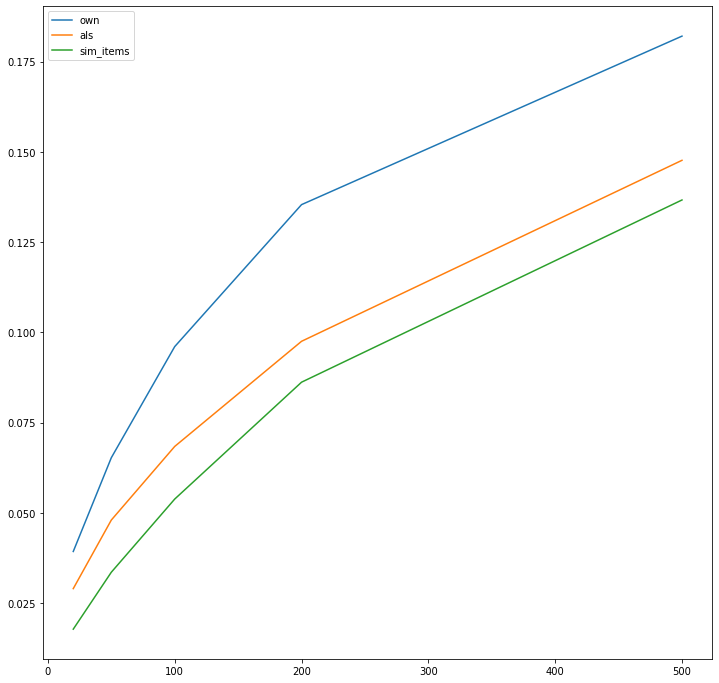

In [26]:
hist.plot(figsize=(12, 12))

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

На графике видно, что после определенного значения (~200) k припрост recall для всех моделей становится одинаковым. если важно операционное время или вычислительная мощность невелика, то я бы ограничился k = 200.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [27]:
result_lvl_1['als_precision'] = result_lvl_1.apply(lambda row: precision_at_k(row['als_candidates'], row['actual'], k=50), axis=1)

In [28]:
als_candidates = result_lvl_1[['user_id', 'als_candidates']]

In [29]:
als_candidates.head() # кандидаты модели первого уровня

,user_id,als_candidates
0,1,"[8090541, 1047619, 1055425, 824758, 883616, 89..."
1,2,"[5569230, 916122, 844179, 1029743, 866211, 100..."
2,4,"[821741, 1091383, 891423, 944588, 6391541, 113..."
3,6,"[1026118, 965267, 1084036, 896613, 1051516, 87..."
4,7,"[839419, 996444, 1100140, 1060408, 6443332, 91..."


In [30]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})

In [31]:
valid_lvl_2 = valid_lvl_2.merge(als_candidates, on='user_id', how='left')

Точность ALS на валидационном датасете


In [32]:
valid_lvl_2[valid_lvl_2.als_candidates.notna()].\
apply(lambda row: precision_at_k(row['als_candidates'], row['actual'], k=5), axis=1).mean()

0.10015665796344603

In [33]:
users_lvl_2 = pd.DataFrame(result_lvl_1['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))

In [34]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [35]:
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.tail(4)

,user_id,item_id,flag
2150,2500,12781828,1
2150,2500,1079228,1
2150,2500,1096556,1
2150,2500,933835,1


In [36]:
data_train_lvl_2 = data_val_lvl_1.copy()

In [38]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)


targets_lvl_2.head()

,user_id,item_id,target
0,1,8090541,0.0
1,1,1047619,0.0
2,1,1055425,0.0
3,1,824758,0.0
4,1,883616,0.0


Фичи item_id

In [39]:

prices = data.groupby('item_id')['sales_value'].max()

In [40]:
item_features = item_features.merge(prices, on='item_id', how='left').rename(columns={'sales_value': 'price'}) # не для всех товаров есть цена
item_features.tail(5)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,,NaN
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,,NaN
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
92352,18316298,764,GROCERY,National,PAPER TOWELS,PAPER TOWELS & HOLDERS,,NaN


In [41]:
avg_price_by_cat = item_features.groupby('commodity_desc')['price'].mean()
item_features = item_features.merge(avg_price_by_cat, on='commodity_desc', how='left').rename(columns={'price_x': 'price', 'price_y': 'avg_price'})

In [43]:
item_features_test = item_features[['item_id',
                                    'manufacturer',
                                    'department',
                                    'brand',
                                    'commodity_desc',
                                    'price',
                                    'avg_price']]


item_features_test.head()

,item_id,manufacturer,department,brand,commodity_desc,price,avg_price
0,25671,2,GROCERY,National,FRZN ICE,13.96,6.811379
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,0.99,6.879213
2,26093,69,PASTRY,Private,BREAD,1.59,3.121493
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,1.54,4.182813
4,26355,69,GROCERY,Private,COOKIES/CONES,1.98,3.730524


Фичи user_id


In [44]:
basket_price = data.groupby('basket_id')['sales_value'].sum()

In [45]:
data = data.merge(basket_price, on='basket_id', how='left').rename(columns={'sales_value_x': 'sales_value', 'sales_value_y': 'basket_price'})

In [46]:
avg_basket_per_user = data.groupby('user_id').basket_price.mean()

In [47]:
user_features = user_features.merge(avg_basket_per_user, on='user_id', how='left')

In [48]:
x = data.groupby(['user_id', 'week_no']).basket_id.count().reset_index().groupby('user_id').agg(['count', 'sum'])

In [49]:
x.columns = x.columns.droplevel(0)

In [50]:
avg_purchases_per_week = x.iloc[:, 2:].apply(lambda row: row['sum']/row['count'], axis=1)

In [51]:
avg_purchases_per_week.name = 'avg_purchases_per_week'

In [52]:
user_features = user_features.merge(avg_purchases_per_week, on='user_id', how='left')

In [55]:
user_features_test = user_features[['user_id',
                                    'age_desc',
                                    'income_desc',
                                    'household_size_desc',
                                    'avg_purchases_per_week',
                                    'basket_price']]

user_features_test.head()

,user_id,age_desc,income_desc,household_size_desc,avg_purchases_per_week,basket_price
0,1,65+,35-49K,2,24.828125,77.419817
1,7,45-54,50-74K,2,24.363636,86.418470
2,8,25-34,25-34K,3,26.409091,82.333861
3,13,25-34,75-99K,4,26.750000,91.693154
4,16,45-54,50-74K,1,9.160714,21.855595


In [56]:
targets_lvl_2 = targets_lvl_2.merge(item_features_test, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features_test, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,price,avg_price,age_desc,income_desc,household_size_desc,avg_purchases_per_week,basket_price
0,1,8090541,0.0,103,GROCERY,National,SOFT DRINKS,25.00,5.947091,65+,35-49K,2,24.828125,77.419817
1,1,1047619,0.0,317,GROCERY,National,SALD DRSNG/SNDWCH SPRD,7.38,3.416009,65+,35-49K,2,24.828125,77.419817


In [57]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']

In [59]:
categorical = ['manufacturer',
               'department',
               'brand',
               'commodity_desc',
               'age_desc',
               'income_desc',
               'household_size_desc']

In [60]:

X_train[categorical] = X_train[categorical].astype('category')

In [61]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=categorical)
lgb.fit(X_train, y_train.values)

train_preds = lgb.predict_proba(X_train)[:, 1] # вероятность покупки

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [62]:
targets_lvl_2['preds'] = train_preds

In [63]:
targets_lvl_2.sort_values(['user_id', 'preds'], ascending=[True, False], inplace=True)

In [64]:
lgb_candidates = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()

lgb_candidates.head()

,user_id,item_id
0,1,"[9655212, 856942, 9527558]"
1,2,"[1029743, 1106523, 1075368, 934172, 1082990]"
2,4,"[987044, 1052294, 1075368, 880888, 891423]"
3,6,"[1082185, 1024306]"
4,7,"[1126899, 1006483, 9338009, 6443332, 916122]"


In [65]:
valid_lvl_2 = valid_lvl_2.merge(lgb_candidates, on='user_id', how='left')

valid_lvl_2.rename(columns={'item_id': 'lgb_candidates'}, inplace=True)

valid_lvl_2[valid_lvl_2.als_candidates.notna()].\
apply(lambda row: precision_at_k(row['lgb_candidates'], row['actual'], k=5), axis=1).mean()


0.18982593559616928